<a href="https://colab.research.google.com/github/michaelholm6/ME592Hwk/blob/main/592_HW4_LL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PFRL Quickstart Guide

This is a quickstart guide for users who just want to try PFRL for the first time.

If you have not yet installed PFRL, run the command below to install it:
```
pip install pfrl
```

If you have already installed PFRL, let's begin!

First, you need to import necessary modules. The module name of PFRL is `pfrl`. Let's import `torch`, `gym`, and `numpy` as well since they are used later.

In [1]:
#installing prerequisite display packages
!apt update && apt install xvfb python-opengl ffmpeg
#install torch and plotting packages
!pip install torchvision matplotlib seaborn pandas numpy pathlib 
#install gym and physics engine for box2d environments
!pip install gym box2d-py

#install wrapper to visualize environment
!pip install gym-notebook-wrapper
!pip install pyvirtualdisplay
import pyvirtualdisplay
disp = pyvirtualdisplay.Display()
disp.start() # Start Xvfb and set "DISPLAY" environment properly.
!pip install pfrl
import pfrl
import torch
import torch.nn
import gym
import numpy

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random, os.path, math, glob, csv, base64, itertools, sys
import gym
from gym.wrappers import Monitor
import gnwrapper


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

PFRL can be used for any problems if they are modeled as "environments". [OpenAI Gym](https://github.com/openai/gym) provides various kinds of benchmark environments and defines the common interface among them. PFRL uses a subset of the interface. Specifically, an environment must define its observation space and action space and have at least two methods: `reset` and `step`.

- `env.reset` will reset the environment to the initial state and return the initial observation.
- `env.step` will execute a given action, move to the next state and return four values:
  - a next observation
  - a scalar reward
  - a boolean value indicating whether the current state is terminal or not
  - additional information
- `env.render` will render the current state. (optional)

Let's try `CartPole-v0`, which is a classic control problem. You can see below that its observation space consists of four real numbers while its action space consists of two discrete actions.

In [2]:
#env = gym.make('CartPole-v1')
env = gym.make('LunarLander-v2')
env.seed(0)
env = gnwrapper.Monitor(env,directory="./train", force=True, video_callable=lambda num: num % 50 == 0) # Start Xvfb, if force=True, overwrites exisiting saved videos
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
print('initial observation:', obs)

action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

# Uncomment to open a GUI window rendering the current state of the environment
env.render()

observation space: Box(-inf, inf, (8,), float32)
action space: Discrete(4)
initial observation: [-5.9156417e-04  1.4134574e+00 -5.9935719e-02  1.1277095e-01
  6.9228926e-04  1.3576316e-02  0.0000000e+00  0.0000000e+00]
next observation: [-1.2460708e-03  1.4154155e+00 -6.7727223e-02  8.7033525e-02
  2.9421085e-03  4.5001026e-02  0.0000000e+00  0.0000000e+00]
reward: 1.291988827466356
done: False
info: {}


True

In [3]:

from collections import deque

Now you have defined your environment. Next, you need to define an agent, which will learn through interactions with the environment.

PFRL provides various agents, each of which implements a deep reinforcement learning algorithm.

Let's try using the DoubleDQN algorithm (https://arxiv.org/abs/1509.06461), which is implemented by `pfrl.agents.DoubleDQN`. This algorithm trains a Q-function that receives an observation and returns an expected future return for each action the agent can take. In PFRL, you can define your Q-function as `torch.nn.Module` as below. Note that the outputs are wrapped by `pfrl.action_value.DiscreteActionValue`. By wrapping the outputs of Q-functions, PFRL can support not only discrete-action Q-functions like this but also continuous-action Q-functions (via [Normalized Advantage Functions](https://arxiv.org/abs/1603.00748)) in the same way.

In [4]:
class QFunction(torch.nn.Module):

    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.l1 = torch.nn.Linear(obs_size, 50)
        self.l2 = torch.nn.Linear(50, 50)
        self.l3 = torch.nn.Linear(50, n_actions)

    def forward(self, x):
        h = x
        h = torch.nn.functional.relu(self.l1(h))
        h = torch.nn.functional.relu(self.l2(h))
        h = self.l3(h)
        return pfrl.action_value.DiscreteActionValue(h)

obs_size = env.observation_space.low.size
n_actions = env.action_space.n
q_func = QFunction(obs_size, n_actions)
print(q_func)

QFunction(
  (l1): Linear(in_features=8, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=4, bias=True)
)


It is also possible to define the same model using `torch.nn.Sequential`. `pfrl.q_functions.DiscreteActionValueHead` is just a `torch.nn.Module` that packs its input to `pfrl.action_value.DiscreteActionValue`.

In [32]:
q_func2 = torch.nn.Sequential(
    torch.nn.Linear(obs_size, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 40),
    torch.nn.ReLU(),
    torch.nn.Linear(40, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 15),
    torch.nn.ReLU(),
    torch.nn.Linear(15, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, n_actions),
    pfrl.q_functions.DiscreteActionValueHead(),
)
print(q_func2)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=30, bias=True)
  (7): ReLU()
  (8): Linear(in_features=30, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=40, bias=True)
  (11): ReLU()
  (12): Linear(in_features=40, out_features=30, bias=True)
  (13): ReLU()
  (14): Linear(in_features=30, out_features=15, bias=True)
  (15): ReLU()
  (16): Linear(in_features=15, out_features=10, bias=True)
  (17): ReLU()
  (18): Linear(in_features=10, out_features=8, bias=True)
  (19): ReLU()
  (20): Linear(in_features=8, out_features=4, bias=True)
  (21): DiscreteActionValueHead()
)


As usual in PyTorch, `torch.optim.Optimizer` is used to optimize a model.

In [33]:
# Use Adam to optimize q_func. eps=1e-2 is for stability.
optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-2)

To create a DoubleDQN agent with the Q-function and optimizer, you need to specify a bit more parameters and configurations.

In [56]:
# Set the discount factor that discounts future rewards.
gamma = 0.99

# Use epsilon-greedy for exploration
explorer = pfrl.explorers.ConstantEpsilonGreedy(
    epsilon=0.99, random_action_func=env.action_space.sample)

# DQN uses Experience Replay.
# Specify a replay buffer and its capacity.
replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10 ** 6)

# Since observations from CartPole-v0 is numpy.float64 while
# As PyTorch only accepts numpy.float32 by default, specify
# a converter as a feature extractor function phi.
phi = lambda x: x.astype(numpy.float32, copy=False)

# Set the device id to use GPU. To use CPU only, set it to -1.
gpu = -1

# Now create an agent that will interact with the environment.
agent = pfrl.agents.DoubleDQN(
    q_func2,
    optimizer,
    replay_buffer,
    gamma,
    explorer,
    replay_start_size=4000,
    update_interval=10,
    target_update_interval=100,
    phi=phi,
    gpu=gpu,
)

Now you have an agent and an environment. It's time to start reinforcement learning!

During training, two methods of `agent` must be called: `agent.act` and `agent.observe`. `agent.act(obs)` takes the current observation as input and returns an exploratory action. Once the returned action is processed in the env, `agent.observe(obs, reward, done, reset)` then observes the consequences:
- `obs`: next observation.
- `reward`: an immediate reward.
- `done`: a boolean value set to True if it reached a terminal state.
- `reset`: a boolean value set to True if an episode is interrupted at a non-terminal state, typically by a time limit.

Optionally, you can get training statistics of the agent via `agent.get_statistics`.

episode: 10 R: -232.83090607918513
statistics: [('average_q', nan), ('average_loss', nan), ('cumulative_steps', 877), ('n_updates', 0), ('rlen', 877)]
episode: 20 R: -147.3815335157676
statistics: [('average_q', nan), ('average_loss', nan), ('cumulative_steps', 1766), ('n_updates', 0), ('rlen', 1766)]
episode: 30 R: -117.73663635645711
statistics: [('average_q', nan), ('average_loss', nan), ('cumulative_steps', 2620), ('n_updates', 0), ('rlen', 2620)]
episode: 40 R: -91.42899164542732
statistics: [('average_q', nan), ('average_loss', nan), ('cumulative_steps', 3643), ('n_updates', 0), ('rlen', 3643)]
episode: 50 R: -69.55966771083206
statistics: [('average_q', -0.12149647), ('average_loss', 2.5778810371052137), ('cumulative_steps', 4540), ('n_updates', 55), ('rlen', 4540)]
episode: 60 R: -52.02805318045709
statistics: [('average_q', -0.11243854), ('average_loss', 1.9998656290769576), ('cumulative_steps', 5382), ('n_updates', 139), ('rlen', 5382)]
episode: 70 R: -138.08682202320878
stat

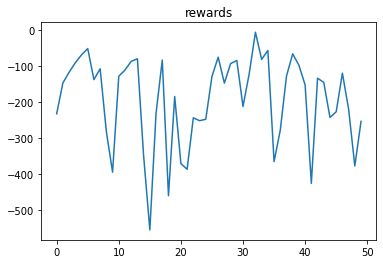

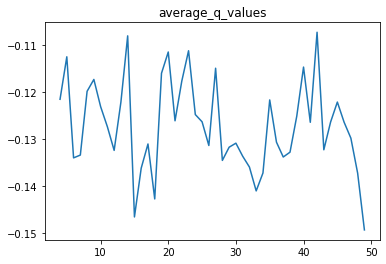

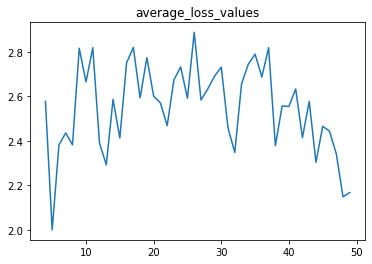

Finished.


In [57]:
import matplotlib.pyplot as plt
n_episodes = 500
rewards = []
average_q_values = []
average_loss_values = []
max_episode_len = 200
for i in range(1, n_episodes + 1):
    obs = env.reset()
    R = 0  # return (sum of rewards)
    t = 0  # time step
    while True:
        # Uncomment to watch the behavior in a GUI window
        env.render()
        action = agent.act(obs) # get action from agent
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
        reset = t == max_episode_len
        agent.observe(obs, reward, done, reset)
        if done or reset:
            break
    if i % 10 == 0:
        rewards.append(R)
        average_q_value = agent.get_statistics()[0][1]
        average_q_values.append(float(average_q_value))
        average_loss = agent.get_statistics()[1][1]
        average_loss_values.append(float(average_loss))
        print('episode:', i, 'R:', R)
        print('statistics:', agent.get_statistics())
plt.plot(rewards)
plt.title("rewards")
plt.show()
plt.plot(average_q_values)
plt.title("average_q_values")
plt.show()
plt.plot(average_loss_values)
plt.title("average_loss_values")
plt.show()
print('Finished.')

Now you finished training the DoubleDQN agent for 300 episodes. How good is the agent now? You can evaluate it by using `with agent.eval_mode()`. Exploration such as epsilon-greedy is not used anymore.

In [58]:
with agent.eval_mode():
    for i in range(30):
        obs = env.reset()
        R = 0
        t = 0
        while True:
            # Uncomment to watch the behavior in a GUI window
            # env.render()
            action = agent.act(obs)
            obs, r, done, _ = env.step(action)
            R += r
            t += 1
            reset = t == 200
            agent.observe(obs, r, done, reset)
            if done or reset:
                break
        print('evaluation episode:', i, 'R:', R)

evaluation episode: 0 R: -611.2994649771819
evaluation episode: 1 R: -546.3115687947076
evaluation episode: 2 R: -932.4010840849471
evaluation episode: 3 R: -714.6185274982086
evaluation episode: 4 R: -1239.0945832894665
evaluation episode: 5 R: -752.7313586609389
evaluation episode: 6 R: -1147.9724590554085
evaluation episode: 7 R: -508.4385766819555
evaluation episode: 8 R: -499.27385693784777
evaluation episode: 9 R: -606.0683385018145
evaluation episode: 10 R: -578.4989960488408
evaluation episode: 11 R: -1455.9245856943185
evaluation episode: 12 R: -550.3016576821806
evaluation episode: 13 R: -396.80785762500244
evaluation episode: 14 R: -757.0580822416658
evaluation episode: 15 R: -540.2426501036963
evaluation episode: 16 R: -665.2176034054211
evaluation episode: 17 R: -977.7028275357508
evaluation episode: 18 R: -639.906484813371
evaluation episode: 19 R: -1040.5913807292463
evaluation episode: 20 R: -621.8778654296614
evaluation episode: 21 R: -926.2610231130831
evaluation epis

For your information, `CartPole-v0`'s maximum achievable return is 200. If the agent could not achieve 200, it was unlucky! You can train the agent longer by running the training loop again.

If the results are good enough, the only remaining task is to save the agent so that you can reuse it. What you need to do is to simply call `agent.save` to save the agent, then `agent.load` to load the saved agent.

In [59]:
env.display()
# Save an agent to the 'agent' directory
agent.save('agent')

# Uncomment to load an agent from the 'agent' directory
# agent.load('agent')

'openaigym.video.0.60.video000000.mp4'

'openaigym.video.0.60.video000050.mp4'

'openaigym.video.0.60.video000100.mp4'

'openaigym.video.0.60.video000150.mp4'

'openaigym.video.0.60.video000200.mp4'

'openaigym.video.0.60.video000250.mp4'

'openaigym.video.0.60.video000300.mp4'

'openaigym.video.0.60.video000350.mp4'

'openaigym.video.0.60.video000400.mp4'

'openaigym.video.0.60.video000450.mp4'

'openaigym.video.0.60.video000500.mp4'

'openaigym.video.0.60.video000550.mp4'

'openaigym.video.0.60.video000600.mp4'

'openaigym.video.0.60.video000650.mp4'

'openaigym.video.0.60.video000700.mp4'

'openaigym.video.0.60.video000750.mp4'

'openaigym.video.0.60.video000800.mp4'

'openaigym.video.0.60.video000850.mp4'

'openaigym.video.0.60.video000900.mp4'

'openaigym.video.0.60.video000950.mp4'

'openaigym.video.0.60.video001000.mp4'

'openaigym.video.0.60.video001050.mp4'

'openaigym.video.0.60.video001100.mp4'

'openaigym.video.0.60.video001150.mp4'

'openaigym.video.0.60.video001200.mp4'

'openaigym.video.0.60.video001250.mp4'

'openaigym.video.0.60.video001300.mp4'

'openaigym.video.0.60.video001350.mp4'

'openaigym.video.0.60.video001400.mp4'

'openaigym.video.0.60.video001450.mp4'

'openaigym.video.0.60.video001500.mp4'

'openaigym.video.0.60.video001550.mp4'

'openaigym.video.0.60.video001600.mp4'

'openaigym.video.0.60.video001650.mp4'

'openaigym.video.0.60.video001700.mp4'

'openaigym.video.0.60.video001750.mp4'

'openaigym.video.0.60.video001800.mp4'

'openaigym.video.0.60.video001850.mp4'

'openaigym.video.0.60.video001900.mp4'

'openaigym.video.0.60.video001950.mp4'

'openaigym.video.0.60.video002000.mp4'

'openaigym.video.0.60.video002050.mp4'

'openaigym.video.0.60.video002100.mp4'

'openaigym.video.0.60.video002150.mp4'

'openaigym.video.0.60.video002200.mp4'

'openaigym.video.0.60.video002250.mp4'

'openaigym.video.0.60.video002300.mp4'

'openaigym.video.0.60.video002350.mp4'

'openaigym.video.0.60.video002400.mp4'

'openaigym.video.0.60.video002450.mp4'

'openaigym.video.0.60.video002500.mp4'

'openaigym.video.0.60.video002550.mp4'

'openaigym.video.0.60.video002600.mp4'

'openaigym.video.0.60.video002650.mp4'

'openaigym.video.0.60.video002700.mp4'

'openaigym.video.0.60.video002750.mp4'

'openaigym.video.0.60.video002800.mp4'

'openaigym.video.0.60.video002850.mp4'

'openaigym.video.0.60.video002900.mp4'

'openaigym.video.0.60.video002950.mp4'

'openaigym.video.0.60.video003000.mp4'

'openaigym.video.0.60.video003050.mp4'

'openaigym.video.0.60.video003100.mp4'

'openaigym.video.0.60.video003150.mp4'

'openaigym.video.0.60.video003200.mp4'

'openaigym.video.0.60.video003250.mp4'

'openaigym.video.0.60.video003300.mp4'

'openaigym.video.0.60.video003350.mp4'

'openaigym.video.0.60.video003400.mp4'

'openaigym.video.0.60.video003450.mp4'

'openaigym.video.0.60.video003500.mp4'

'openaigym.video.0.60.video003550.mp4'

'openaigym.video.0.60.video003600.mp4'

'openaigym.video.0.60.video003650.mp4'

'openaigym.video.0.60.video003700.mp4'

'openaigym.video.0.60.video003750.mp4'

'openaigym.video.0.60.video003800.mp4'

'openaigym.video.0.60.video003850.mp4'

'openaigym.video.0.60.video003900.mp4'

'openaigym.video.0.60.video003950.mp4'

'openaigym.video.0.60.video004000.mp4'

'openaigym.video.0.60.video004050.mp4'

'openaigym.video.0.60.video004100.mp4'

'openaigym.video.0.60.video004150.mp4'

'openaigym.video.0.60.video004200.mp4'

'openaigym.video.0.60.video004250.mp4'

'openaigym.video.0.60.video004300.mp4'

'openaigym.video.0.60.video004350.mp4'

'openaigym.video.0.60.video004400.mp4'

'openaigym.video.0.60.video004450.mp4'

'openaigym.video.0.60.video004500.mp4'

'openaigym.video.0.60.video004550.mp4'

RL completed!

But writing code like this every time you use RL might be tedious. So, PFRL has utility functions that do these things.

In [11]:
# Set up the logger to print info messages for understandability.
import logging
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout, format='')

pfrl.experiments.train_agent_with_evaluation(
    agent,
    env,
    steps=2000,           # Train the agent for 2000 steps
    eval_n_steps=None,       # We evaluate for episodes, not time
    eval_n_episodes=10,       # 10 episodes are sampled for each evaluation
    train_max_episode_len=200,  # Maximum length of each episode
    eval_interval=1000,   # Evaluate the agent after every 1000 steps
    outdir='result',      # Save everything to 'result' directory
)

outdir:result step:102 episode:0 R:-94.66503367032814
statistics:[('average_q', 6.141634), ('average_loss', 1.4601941685378552), ('cumulative_steps', 48094), ('n_updates', 47595), ('rlen', 48094)]
outdir:result step:230 episode:1 R:-19.755154524386356
statistics:[('average_q', 7.362043), ('average_loss', 1.3232389602810144), ('cumulative_steps', 48222), ('n_updates', 47723), ('rlen', 48222)]
outdir:result step:298 episode:2 R:-138.20888175345186
statistics:[('average_q', 5.545088), ('average_loss', 1.1893285585939883), ('cumulative_steps', 48290), ('n_updates', 47791), ('rlen', 48290)]
outdir:result step:409 episode:3 R:-108.40191637367207
statistics:[('average_q', 5.8683085), ('average_loss', 1.3729813942313194), ('cumulative_steps', 48401), ('n_updates', 47902), ('rlen', 48401)]
outdir:result step:490 episode:4 R:-90.36121071805493
statistics:[('average_q', 6.9781756), ('average_loss', 1.0846761278808117), ('cumulative_steps', 48482), ('n_updates', 47983), ('rlen', 48482)]
outdir:res

(<pfrl.agents.double_dqn.DoubleDQN at 0x7f4c5b28f910>,
 [{'average_loss': 1.4662325331568717,
   'average_q': 5.267254,
   'cumulative_steps': 49059,
   'eval_score': 12.16942040079233,
   'n_updates': 48560,
   'rlen': 49059},
  {'average_loss': 1.3845565785467624,
   'average_q': 5.714147,
   'cumulative_steps': 49992,
   'eval_score': 8.270101189190104,
   'n_updates': 49493,
   'rlen': 49992}])

That's all of the PFRL quickstart guide. To know more about PFRL, please look into the `examples` directory and read and run the examples. Thank you!